# Import stuff

In [5]:
pip install adjusttext

  Created wheel for adjusttext: filename=adjustText-0.7.3-cp37-none-any.whl size=7100 sha256=f9cc1edd15aa6d6319ddf234d1d31271c3a70d0fceea71da392af872c64f5fb6
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjusttext


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from adjustText import adjust_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Load Dataset

In [50]:
playlists_df = pd.read_csv('./spotify_recom.csv')
playlists_df = playlists_df.drop(columns= ['id', 'playlist_id', 'artist_name', 'artistid', 'name', 'username', 'added_at'])

playlists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2261 entries, 0 to 2260
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   playlist_name  2261 non-null   object 
 1   explicit       2261 non-null   bool   
 2   duration       2261 non-null   int64  
 3   popularity     2261 non-null   int64  
 4   danceability   2223 non-null   float64
 5   loudness       2223 non-null   float64
 6   tempo          2223 non-null   float64
 7   acousticness   2223 non-null   float64
 8   energy         2223 non-null   float64
 9   valence        2223 non-null   float64
 10  liveness       2223 non-null   float64
 11  speechiness    2223 non-null   float64
 12  genres         2261 non-null   object 
dtypes: bool(1), float64(8), int64(2), object(2)
memory usage: 214.3+ KB


In [51]:
playlists_df.head()

,playlist_name,explicit,duration,popularity,danceability,loudness,tempo,acousticness,energy,valence,liveness,speechiness,genres
0,Rock Classics,False,333893,76,0.412,-11.600,89.740,0.04840,0.902,0.422,0.4050,0.4050,"['album rock', 'classic rock', 'hard rock', 'r..."
1,Rock & Roll Party,False,333893,76,0.412,-11.600,89.740,0.04840,0.902,0.422,0.4050,0.4050,"['album rock', 'classic rock', 'hard rock', 'r..."
2,Rock Classics,False,240800,76,0.438,-6.237,113.253,0.00255,0.805,0.564,0.0842,0.0624,"['acid rock', 'blues rock', 'classic rock', 'p..."
3,Rock Classics,False,210160,69,0.346,-5.695,169.492,0.00603,0.768,0.532,0.0244,0.0377,"['acid rock', 'blues rock', 'classic rock', 'p..."
4,Rock Classics,False,170813,70,0.533,-5.270,108.900,0.00876,0.905,0.486,0.0698,0.0754,"['acid rock', 'blues rock', 'classic rock', 'p..."


# Preprocessing


## Samples containing any NaN values are removed completely

In [52]:

playlists_df = playlists_df.drop(playlists_df[playlists_df['loudness'].isna()].index)
playlists_df['popularity'] = playlists_df['popularity'].astype(np.float64) / 100
playlists_df['duration'] = playlists_df['duration'].astype(np.float64)
playlists_df['explicit'] = playlists_df['explicit'].astype(np.float64)

# Create list from genre column! (God knows how much i tried)
playlists_df['genres'] = playlists_df['genres'].apply(lambda x: x.strip('[]').replace('\'', '').replace('\"', '').replace(', ', ',').replace(' ', '').split(','))
playlists_df['genres'] = playlists_df['genres'].apply(lambda x: [i for i in x if len(i) != 0])
playlists_df = playlists_df.drop([index for index, key in playlists_df['genres'].items() if len(key) == 0])

# Integer encode playlist names
playlist_encoder = OrdinalEncoder()
playlist_name = playlist_encoder.fit_transform(playlists_df['playlist_name'].to_numpy().reshape(-1, 1))

playlist_name.shape

(2114, 1)

In [53]:
playlists_df['genres'].head()

0             [albumrock, classicrock, hardrock, rock]
1             [albumrock, classicrock, hardrock, rock]
2    [acidrock, bluesrock, classicrock, psychedelic...
3    [acidrock, bluesrock, classicrock, psychedelic...
4    [acidrock, bluesrock, classicrock, psychedelic...
Name: genres, dtype: object

## Split train and test

In [54]:
# Split train and test
X_train, X_test, playlist_train, playlist_test = train_test_split(playlists_df.drop(columns=['playlist_name']), playlist_name, test_size=0.2, random_state=0)

X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

X_train.shape, X_test.shape

((1691, 13), (423, 13))

## scale and whiten float columns

In [55]:
float_cols = X_train.dtypes[X_train.dtypes == 'float64'].index.values

floats_train = X_train[float_cols]
floats_test = X_test[float_cols]

genres_train = X_train['genres']
genres_test = X_test['genres']

#scale and whiten float columns
scaler = StandardScaler()
pca = PCA(whiten = True)

floats_train = pd.DataFrame(pca.fit_transform(scaler.fit_transform(floats_train)), columns = floats_train.columns)
# Dont fit test features
floats_test = pd.DataFrame(pca.transform(scaler.transform(floats_test)), columns = floats_test.columns)

## Get most repeated genres

In [56]:
counts = genres_train.apply(lambda x: pd.Series(x).value_counts()).sum()
Most_Frequent = counts[counts > 100].index.to_numpy()

counts.sort_values()[::-1][:10]

indiefolk           275.0
classicrock         183.0
newamericana        173.0
rock                146.0
alternativerock     145.0
dancehall           124.0
deepnewamericana    104.0
permanentwave       103.0
folk                102.0
latin               100.0
dtype: float64

In [60]:
# replace genres in test dataset that are not present in train vocabulary with most frequent genre (least important :D)
for index, gens in genres_test.items():
  for i, gen in enumerate(gens):
    if gen not in word2vec_model.wv.vocab.keys():
      print(genres_test[index][i])
      genres_test[index][i] = 'indiefolk'

alabamaindie
jazztrumpet
ukalternativehiphop
synthpop
brooklyndrill
modernalternativepop
brooklyndrill
funkpop
pagodebaiano
funkpop
pagodebaiano
ukalternativehiphop
alabamaindie
synthpop
rapromantico
modernalternativepop


# Task 1
In this task, I treat each genre list of a song as a sentence and use a Word2Vec model to embed the genres. I expect this to work because I expect all genres of one particular song to be alike.

This gives me an embedding for each genre, but each song has a list of genres. So, to get a representation of genre for a particular song I compute the mean of all genre embeddings of that song.

However, some genres are not very definitive as others. For example, songs of Taylor swift all have 'Rock' in their genres and so do AC/DC songs... whereas existance of some genre like 'Iranian folk' in a song is rare and would be of high importance. To address this issue, I compute a TF-IDF based weighted averaging in which I value occurance of rare genres over high-repeating ones

In the end, because in our minds there are not more than a few dozen genres whereas in this dataset there are nearly 500!!!! with agglomerative clustering, I form 10 genre labels from the genre embeddings as main genres and try to predict which genre cluster a new song belongs to. I do this by the training on the song features (Tempo, valence, loudness, ...)

I also plot the embeddings with TSNE for visual ease of understanding.

In [22]:
word2vec_model = Word2Vec(genres_train, min_count=1, size = 20)

# Length of vocabulary
len(list(word2vec_model.wv.vocab))

493

In [23]:
word2vec_model.wv.vocab.keys()

dict_keys(['dancehall', 'soca', 'calirap', 'afrohouse', 'afrosoul', 'amapiano', 'southafricanalternative', 'southafricanpop', 'modernreggae', 'reggaefusion', 'ukamericana', 'indieanthem-folk', 'indiecafepop', 'indiefolk', 'vaporsoul', 'newamericana', 'popfolk', 'stompandflutter', 'stompandholler', 'albumrock', 'classicrock', 'hardrock', 'heartlandrock', 'mellowgold', 'alternativemetal', 'alternativerock', 'artrock', 'comic', 'funkmetal', 'jamgrass', 'midwestamericana', 'afrobeat', 'funk', 'instrumentalfunk', 'latinafrobeat', 'australianindie', 'folk-pop', 'indiepop', 'afropop', 'alte', 'alternativer&b', 'indier&b', 'nigerianpop', 'americanfolkrevival', 'brillbuildingpop', 'bubblegumpop', 'folk', 'folkrock', 'countryrock', 'permanentwave', 'rock', 'latin', 'reggaeton', 'reggaetonflow', 'trapboricua', 'traplatino', 'nycrap', 'ukdancehall', 'beatlesque', 'britishinvasion', 'poprock', 'houstonrap', 'popr&b', 'alternativecountry', 'deepnewamericana', 'modernfolkrock', 'latinpop', 'popvenezo

In [24]:
word2vec_model.most_similar(positive=['deltablues'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('nigerianhiphop', 0.8565400242805481),
 ('azontobeats', 0.8548082709312439),
 ('bebop', 0.8457813858985901),
 ('motown', 0.833912193775177),
 ('deepnewamericana', 0.8313355445861816),
 ('freejazz', 0.8162166476249695),
 ('newamericana', 0.8139166831970215),
 ('cooljazz', 0.8126079440116882),
 ('dancerock', 0.8116085529327393),
 ('acousticblues', 0.8112803101539612)]

In [26]:
#tfidf genre lists for weighted averaging on Word2Vec
tfidf = TfidfVectorizer(token_pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+')

tfidf_matrix_train =  tfidf.fit_transform(genres_train.apply(lambda x: " ".join(x)))
genre_weight_train = pd.DataFrame(tfidf_matrix_train.toarray())
genre_weight_train.columns = [i for i in tfidf.get_feature_names()]

# Dont fit test
tfidf_matrix_test = tfidf.transform(genres_test.apply(lambda x: " ".join(x)))
genre_weight_test = pd.DataFrame(tfidf_matrix_test.toarray())
genre_weight_test.columns = [i for i in tfidf.get_feature_names()]

genre_weight_train.head()

,acidrock,acousticblues,acousticpop,acousticpunk,adultstandards,africanelectronic,afrobeat,afrodancehall,afrofuturismobrasileiro,afrohouse,afropop,afropsych,afror&b,afrosoul,afroswing,alabamarap,albumrock,alte,alternativeamericana,alternativecountry,alternativehiphop,alternativemetal,alternativepop,alternativer&b,alternativerock,alternativerootsrock,amapiano,ambientfolk,americanfolkrevival,anti-folk,appalachianfolk,arabfolk,argentinehiphop,arkansascountry,artpop,artpunk,artrock,asakaa,ashevilleindie,atlhiphop,...,tipico,torchsong,traditionalblues,traditionalcountry,traditionalfolk,trap,trapargentino,trapboricua,trapchileno,traplatino,trapqueen,trapsoul,tropical,tuaregguitar,tucsonindie,ugandanpop,ukalternativepop,ukamericana,ukcontemporaryjazz,ukcontemporaryr&b,ukdancehall,ukhiphop,ukreggae,undergroundhiphop,urbancontemporary,urbanoespanol,vancouverindie,vaporsoul,vaportrap,victoriabcindie,viralpop,viralrap,vocaljazz,wellingtonindie,westcoastrap,westernswing,womensmusic,world,yodeling,zolo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49525,0.0,0.0,0.0,0.407525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
genres_train.shape

(1691,)

In [28]:
# TFIDF Averaging the words vectors to represent a genre

genre_embedding_train = []

for indx, row in genres_train.items():
  genre_vector = 0
  for item in row:
    genre_vector += word2vec_model[item] * genre_weight_train.loc[indx, item]
  genre_embedding_train.append(genre_vector)


# Test dataset:

genre_embedding_test = []

for indx, row in genres_test.items():
  genre_vector = 0
  for item in row:
    genre_vector += word2vec_model[item] * genre_weight_test.loc[indx, item]
  genre_embedding_test.append(genre_vector)


print('shape of new genre vectors : ' , np.shape(genre_embedding_test))
your_word_vector = genre_embedding_test[0]
print(' example ' , genre_embedding_test[0])
word2vec_model.most_similar(positive=[your_word_vector], topn=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


shape of new genre vectors :  (423, 20)
 example  [ 0.08148024 -0.06652807 -0.07742234  0.10756716  0.10796123 -0.00552574
  0.04766444  0.0280889   0.03312344  0.02626908  0.00932164  0.01722467
  0.02961114  0.0762406   0.03879875  0.04735575 -0.00279431 -0.06603581
  0.01522187 -0.04371628]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


[('cooljazz', 0.963150680065155),
 ('bebop', 0.9310359358787537),
 ('hardbop', 0.9215236902236938),
 ('indiefolk', 0.9127137660980225),
 ('motown', 0.9115400314331055)]

In [29]:
genre_embedding_train[:2]

[array([ 0.03391959,  0.00415723, -0.00632705,  0.06378631,  0.02922479,
         0.00373628,  0.04321995, -0.02258677,  0.01842585,  0.02158348,
        -0.02971579, -0.00592611,  0.0333547 ,  0.05768564, -0.01711128,
        -0.02368142,  0.00144427, -0.02744808, -0.0242654 , -0.04524044],
       dtype=float32),
 array([ 0.00178259,  0.02000591, -0.01669097,  0.04267052,  0.03447001,
        -0.01092395,  0.00414344, -0.01683134, -0.0066373 ,  0.02272023,
        -0.01869563,  0.0224511 ,  0.0226349 , -0.01054757,  0.01351587,
         0.0180619 ,  0.02360296, -0.02706533, -0.0186991 , -0.00076724],
       dtype=float32)]

In [30]:
# Convert to dataframe
genre_embedding_train = pd.DataFrame(genre_embedding_train, columns = ['genre_%d' % (i) for i in range(20)])

genre_embedding_test = pd.DataFrame(genre_embedding_test, columns = ['genre_%d' % (i) for i in range(20)])

genre_embedding_train.head()

,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18,genre_19
0,0.033920,0.004157,-0.006327,0.063786,0.029225,0.003736,0.043220,-0.022587,0.018426,0.021583,-0.029716,-0.005926,0.033355,0.057686,-0.017111,-0.023681,0.001444,-0.027448,-0.024265,-0.045240
1,0.001783,0.020006,-0.016691,0.042671,0.034470,-0.010924,0.004143,-0.016831,-0.006637,0.022720,-0.018696,0.022451,0.022635,-0.010548,0.013516,0.018062,0.023603,-0.027065,-0.018699,-0.000767
2,0.026599,-0.015240,-0.024349,0.067355,0.051053,0.008061,0.010340,-0.010743,0.015664,-0.003409,-0.019575,0.034103,0.007357,0.023393,0.035743,0.002943,0.007354,-0.034996,-0.006840,-0.004405
3,0.056368,-0.014682,-0.033757,0.086899,0.057884,-0.006180,0.027039,-0.024952,0.007061,-0.001499,-0.009696,-0.010342,0.040731,0.079852,0.013934,-0.032511,-0.010341,-0.038293,-0.018537,-0.056546
4,0.021392,0.001432,-0.020855,0.025264,0.030452,-0.011007,-0.019100,0.008451,0.017135,-0.007339,0.005857,-0.013900,-0.003382,0.020780,0.024847,-0.012409,-0.013549,-0.016220,0.011507,-0.009450


In [31]:
# Get all corpus embeddings
X = word2vec_model[word2vec_model.wv.vocab]

# Agglomerative Clustering (Assume 10 genres)
kmeans = cluster.AgglomerativeClustering(n_clusters = 10)
assigned_clusters  = kmeans.fit_predict(X)

# compose a dictionary for corpus containing the cluster number and it's genres
clusters = {}
n = 0
for n, item in enumerate(assigned_clusters):
    word = word2vec_model.most_similar([X[n]], [],  topn=20)
    word = [w[0] for w in word if w[1] > 0.9]
    if item in clusters: 
        clusters[item].append(word)
    else:
        clusters[item] = [word]

# Print a genre for each cluster
for item in clusters:
    print("Cluster ", item)
    values, counts = np.unique(clusters[item], return_counts=True)
    ind = counts.argsort()[::-1]
    print(np.array([values[i] for i in ind[:1]]).reshape(-1)) 

Cluster  2
['tropical']
Cluster  4
['torchsong']
Cluster  1
['viralrap']
Cluster  7
['world']
Cluster  3
['womensmusic']
Cluster  8
['ukhiphop']
Cluster  6
['zolo']
Cluster  5
['stompandholler' 'pop' 'poprap' 'alternativemetal' 'reggae']
Cluster  0
['vocaljazz']
Cluster  9
['vaportrap']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
No handles with labels found to put in legend.


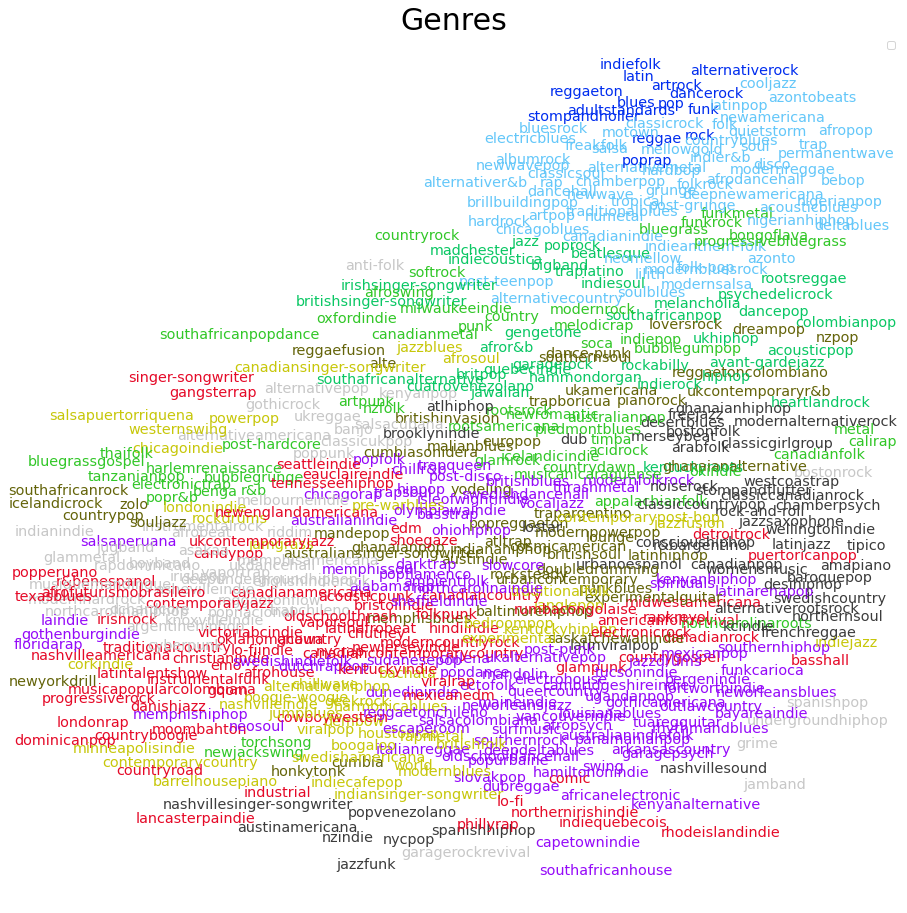

In [34]:
# Plot TSNE 

DarkColourPalette = [
[150,10,250],
[230,10,40], 
[100,200,250], 
[60,60,60],
[50,200,40],
[0,45,240] ,
[100,100,10], 
[200,200,10],
[10,200,100], 
[200,200,200]
]
DarkColourPalette =np.asarray(DarkColourPalette, dtype=float) / 256 


def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=1)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    plt.scatter(x,y, c=kmeans.labels_, cmap='rainbow', alpha=0)  
    
    texts = [ plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     label = str(kmeans.labels_[i]),
                     textcoords='offset points',
                     color=DarkColourPalette[kmeans.labels_[i]],
                     #cmap='rainbow',
                     ha='right',
                     va='bottom', fontsize= 'x-large') for i in range(len(x)) ]
    adjust_text(texts)
    plt.legend()
    plt.axis('off')
    plt.title('Genres',  fontsize=30)
    plt.savefig('./genres.png')
    plt.show()
    
tsne_plot(word2vec_model)

In [41]:
# Create labels for training and testing from learnt clusters
train_y  = kmeans.fit_predict(genre_embedding_train)

# Learn test labels by a supervised method (the nearest neighbor in train dataset)
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(genre_embedding_train, train_y)
test_y = knn.predict(genre_embedding_test)

print(test_y.shape, train_y.shape)

(423,) (1691,)


In [42]:
# Train a randomforest classifier to predict genre clusters of new songs by their song features
# cross validate and grid search for best parameters

X_train, X_test, y_train, y_test = floats_train, floats_test, train_y, test_y

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [1, 10, 20],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1, 50, 100]
}

clf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   49.3s finished


{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

In [43]:
# Get accuracy on test data (Its pretty good :) )
best_grid = grid_search.best_estimator_

grid_accuracy = best_grid.score(X_test, y_test)
grid_accuracy

0.8676122931442081

# TASK 2

In this task I treated each playlist like a document and each genre list of a song as a sentence. In this way I can acheive an embedding for genre of a song directly.

In the end I evaluated the embedding by building a classifier that predicts which playlist a song belongs to. One time only using the genre embeddings as features, another time using song features (tempo, valence, loudness, ...) alongside the embeddings.

In [95]:
from gensim.models.doc2vec import TaggedDocument

# Create Tagged Documents as input for Doc2Vec
train_docs = []
for i, genres in enumerate(genres_train):
  train_docs.append(TaggedDocument(words=genres, tags=[playlist_train[i][0].astype(int)]))
test_docs = []
for i, genres in enumerate(genres_test):
  test_docs.append(TaggedDocument(words=genres, tags=[playlist_test[i][0].astype(int)]))

model_dbow = Doc2Vec(dm=0, vector_size=20, negative=5, hs=0, min_count=1, sample = 0)
model_dbow.build_vocab(train_docs)

In [96]:
# Training
from sklearn import utils

for epoch in range(30):
    model_dbow.train(utils.shuffle(train_docs), total_examples=len(train_docs), epochs=1)
    # Decrease learning rate
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [97]:
tokens = ['chicagoblues', 'deltablues']

# get top 10 document tags and their cosine similarity
new_vector = model_dbow.infer_vector(tokens)
sims = model_dbow.docvecs.most_similar([new_vector]) 

# Print most similar genre lists to my token
for sim in sims:
  print(train_docs[sim[0]][0])

['indieanthem-folk', 'indiecafepop', 'indiefolk', 'vaporsoul']
['ukamericana']
['blues', 'bluesrock', 'chicagoblues', 'deltablues', 'electricblues']
['adultstandards', 'brillbuildingpop', 'rock-and-roll', 'rockabilly']
['australianindiefolk', 'indiefolk', 'stompandholler']
['indiefolk', 'indiepop', 'stompandholler']
['dancehall', 'modernreggae', 'reggaefusion', 'soca']
['classicrock', 'folk', 'folkrock', 'mellowgold', 'rock']
['adultstandards', 'funk', 'motown', 'quietstorm', 'soul']
['reggaeton', 'reggaetonflow', 'traplatino']


In [98]:
# Get embedding of all train and test genres

genre_embedding_train = []
for indx, row in genres_train.items():
  genre_vector = model_dbow.infer_vector(row)
  genre_embedding_train.append(genre_vector)

# Test dataset:
genre_embedding_test = []
for indx, row in genres_test.items():
  genre_vector = model_dbow.infer_vector(row)
  genre_embedding_test.append(genre_vector)

print('shape of new test genre vectors : ' , np.shape(genre_embedding_test))

# Convert to dataframe
genre_embedding_train = pd.DataFrame(genre_embedding_train, columns = ['genre_%d' % (i) for i in range(20)])
genre_embedding_test = pd.DataFrame(genre_embedding_test, columns = ['genre_%d' % (i) for i in range(20)])
genre_embedding_train.head()

shape of new test genre vectors :  (423, 20)


,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18,genre_19
0,0.014989,0.025289,-0.021800,-0.040054,-0.039486,0.022621,0.016211,-0.076326,0.018761,-0.042739,-0.033133,-0.051519,0.073659,-0.013783,-0.038472,-0.023911,0.022168,0.015670,-0.030496,0.020311
1,0.014388,0.016000,0.003449,-0.052243,-0.044403,0.042275,0.016174,-0.161882,-0.038178,-0.105435,0.022326,-0.046954,0.061030,0.036213,-0.040655,-0.021986,0.008871,0.018022,-0.012384,-0.038332
2,-0.003420,0.222643,-0.048101,-0.116642,-0.119815,0.140158,0.027195,-0.718874,-0.039485,-0.441418,0.093545,-0.358119,0.340535,0.167163,-0.138966,0.070928,-0.000920,0.107964,-0.075674,-0.105449
3,0.010143,0.115871,-0.029533,-0.056735,-0.081897,0.069263,0.004119,-0.348344,-0.022612,-0.200929,0.029402,-0.153826,0.194551,0.090987,-0.094450,-0.014953,0.021114,0.069772,-0.053208,-0.022247
4,0.008881,-0.017225,-0.004298,-0.046714,-0.001970,0.016680,-0.004687,-0.024763,-0.006793,-0.037580,0.025304,-0.013175,0.031758,-0.014795,-0.016924,0.007543,0.048858,0.009038,-0.022719,-0.024051


In [101]:
# Agglomerative Clustering (Assume 10 genres)
kmeans = cluster.AgglomerativeClustering(n_clusters = 10)

# Repeat training proceess 
assigned_clusters  = kmeans.fit_predict(genre_embedding_train)
train_y  = kmeans.fit_predict(genre_embedding_train)

# Learn test labels by a supervised method (the nearest neighbor in train dataset)
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(genre_embedding_train, train_y)
test_y = knn.predict(genre_embedding_test)

print(test_y.shape, train_y.shape)

(423,) (1691,)


In [102]:
# Train a randomforest classifier to predict genre clusters of new songs by their song features
# cross validate and grid search for best parameters

X_train, X_test, y_train, y_test = floats_train, floats_test, train_y, test_y

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [1, 10, 20],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1, 50, 100]
}

clf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   50.4s finished


{'max_depth': 20,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 50}

In [103]:
# Get accuracy on test data (Its pretty good :) )
best_grid = grid_search.best_estimator_

grid_accuracy = best_grid.score(X_test, y_test)
grid_accuracy

0.2860520094562648

# Conclusion

First task gave much better results!